In [1]:
import torch
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt
import random
import numpy as np
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.autograd import Variable
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [70]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
from keras.datasets import mnist 
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


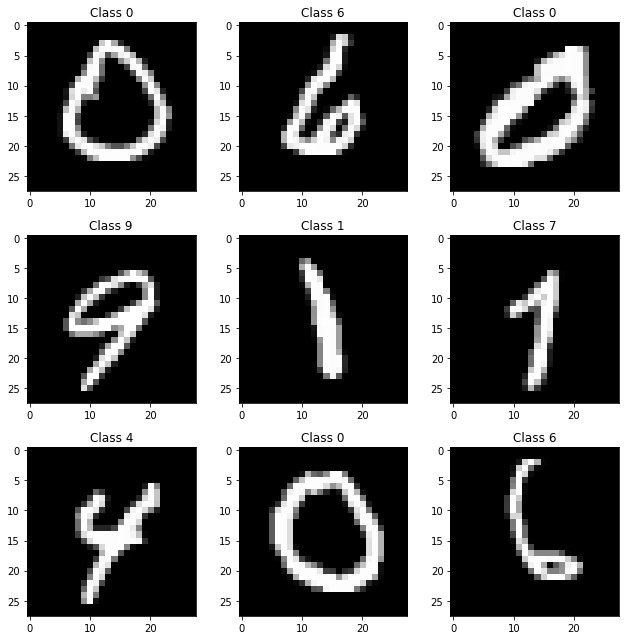

In [72]:
plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))
    
plt.tight_layout()

In [3]:
train_x, val_x, train_y, val_y = train_test_split(X_train, y_train, test_size = 0.1)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((54000, 28, 28), (54000,)), ((6000, 28, 28), (6000,)))

In [4]:
X_train=np.reshape(X_train,(60000,1,28,28))
X_test=np.reshape(X_test,(10000,1,28,28))
val_x=np.reshape(val_x,(6000,1,28,28))
print(X_train.shape)
print(X_test.shape)

(60000, 1, 28, 28)
(10000, 1, 28, 28)


In [5]:
X_train=torch.from_numpy(X_train)
X_test=torch.from_numpy(X_test)
y_train=torch.from_numpy(y_train)
y_test=torch.from_numpy(y_test)
val_x=torch.from_numpy(val_x)
val_y=torch.from_numpy(val_y)


In [6]:
X_train=X_train.float()
X_test=X_test.float()
val_x=val_x.float()
X_train=X_train/255.0
X_test=X_test/255.0


In [7]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(4 * 7 * 7, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [8]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


In [9]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, yt_train = Variable(X_train), Variable(y_train)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        yt_train = yt_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, yt_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [10]:
# defining the number of epochs
n_epochs = 21
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : tensor(2.4436, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  3 	 loss : tensor(4.6998, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  5 	 loss : tensor(2.6163, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  7 	 loss : tensor(1.8450, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  9 	 loss : tensor(1.5840, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  11 	 loss : tensor(1.4155, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  13 	 loss : tensor(1.2007, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  15 	 loss : tensor(0.9627, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  17 	 loss : tensor(0.7919, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  19 	 loss : tensor(0.6871, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  21 	 loss : tensor(0.6151, device='cuda:0', grad_fn=<NllLossBackward0>)


In [11]:
# prediction for validation set
with torch.no_grad():
    output = model(X_train.cuda())

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on validation set
accuracy_score(y_train, predictions)

0.7975666666666666

In [12]:
# prediction for validation set
with torch.no_grad():
    output = model(val_x.cuda())

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on validation set
accuracy_score(val_y, predictions)

0.8018333333333333